# Predicting Price with Neighborhood

In [ ]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

#Prepare Data

##Import

In [ ]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    df["neighborhood"]=df["place_with_parent_names"].astype(str).str.split("|",expand=True)[3].astype(str)
    df.drop(columns=["place_with_parent_names"],inplace=True)

    return df
files = glob("data/buenos-aires-real-estate-*.csv")
frames = []
for file in files:
    df=wrangle(file)
    frames.append(df)


In [ ]:
df = pd.concat(frames,ignore_index=True)
df.info()

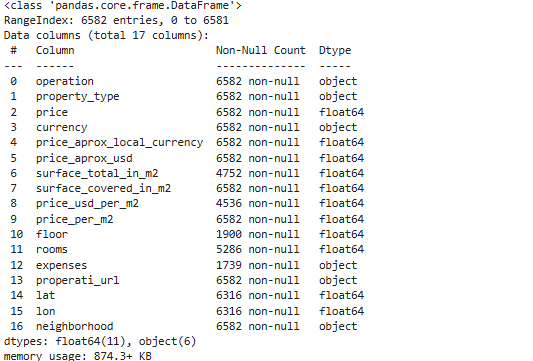

#Split

In [ ]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [ ]:
y_mean = y_train.mean()
y_pred_baseline =[y_mean]*len(y_train)

print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

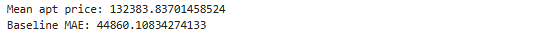

#Iterate

In [ ]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train,y_train)
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2)) # Training MAE: 39350.22

#Communicate Results

In [ ]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients,index=feature_names)

In [ ]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

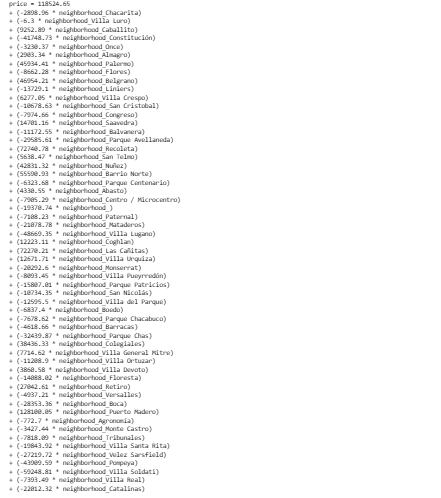

In [ ]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Size");

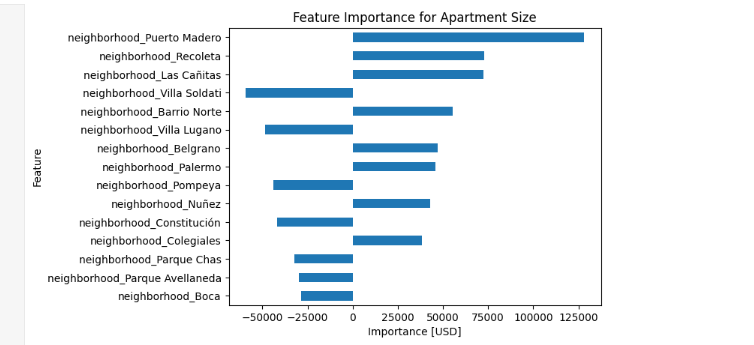